In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"
# jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import yaml
# import meshio
from pathlib import Path
from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random
import optax
from tqdm.auto import tqdm
from typing import Callable
import pickle
import equinox as eqx

from triangular_transport.flows.flow_trainer import (
    NNTrainer,
)

from triangular_transport.flows.interpolants import (
    linear_interpolant,
    linear_interpolant_der,
    trig_interpolant,
    trig_interpolant_der,
    sigmoid_interpolant,
    sigmoid_interpolant_der,
)
from triangular_transport.flows.loss_functions import vec_field_loss
# from triangular_transport.networks.flow_networks import MLP, MLP_Triangular
from triangular_transport.flows.methods.utils import UnitGaussianNormalizer
from triangular_transport.flows.dataloaders import gaussian_reference_sampler
from triangular_transport.kernels.kernel_tools import get_gaussianRBF, vectorize_kfunc

import json
import h5py

import argparse

# plt.style.use("ggplot")

/home/verano13/miniconda3/envs/stochastic-interpolants/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Callable, List

class MLP(eqx.Module):
    layers: List[eqx.nn.Linear]         # main hidden layers
    norms:  List[eqx.nn.LayerNorm]      # per-layer norms (stateless, no BN state)
    skips:  List[eqx.nn.Linear | None]  # projections for residuals (or None for identity)
    out:    eqx.nn.Linear
    activation_fn: List[Callable]

    def __init__(
        self,
        key: jax.random.PRNGKey,
        dim: int,
        out_dim: int | None = None,
        num_layers: int = 4,
        activation_fn: List[Callable] | Callable = jax.nn.gelu,
        w: int | List[int] = 64,
        time_varying: bool = False,
    ):
        if out_dim is None:
            out_dim = dim

        # normalize activation list
        if isinstance(activation_fn, list):
            if len(activation_fn) == 1:
                activation_fn *= num_layers - 1
        else:
            activation_fn = [activation_fn] * (num_layers - 1)
        self.activation_fn = activation_fn

        # normalize widths
        if isinstance(w, list):
            if len(w) == 1:
                w *= (num_layers - 1)
            widths = w
        else:
            widths = [w] * (num_layers - 1)

        k = jax.random.split(key, 2 * num_layers + 1)

        in_dim0 = dim + (1 if time_varying else 0)

        self.layers = []
        self.norms  = []
        self.skips  = []

        in_dim = in_dim0
        for i, width in enumerate(widths):
            # main linear
            lin = eqx.nn.Linear(in_dim, width, key=k[i])
            self.layers.append(lin)

            # lightweight, stateless normalization over features
            self.norms.append(eqx.nn.LayerNorm(width))

            # residual projection if needed
            if in_dim == width:
                self.skips.append(None)
            else:
                self.skips.append(eqx.nn.Linear(in_dim, width, key=k[i + num_layers]))

            in_dim = width

        # output layer
        self.out = eqx.nn.Linear(in_dim, out_dim, key=k[-1])

    def __call__(self, x):
        for layer, norm, skip, act in zip(self.layers, self.norms, self.skips, self.activation_fn):
            h = layer(x)
            h = norm(h)      # normalize pre-activation
            h = act(h)
            s = x if skip is None else skip(x)
            x = h + s
        return self.out(x)


In [3]:
def read_data_h5(path="data.h5"):
    with h5py.File(path, "r") as f:
        targets = f["/target"][...]
        data = f["/data"][...]
    return targets, data

In [ ]:
with open("poisson.yaml") as fid:
    inargs = yaml.full_load(fid)

# utrue = np.load("training_dataset/true_param_grid.npy")
# ytrue = np.load("training_dataset/true_state_grid.npy")
map_est = np.load("training_dataset/map_param_grid.npy")
targets, yobs = read_data_h5()

In [5]:
# nsamples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]
nsamples = 20000

hmala_samps = np.load("training_dataset/chain_30/hmala_samples_grid_delta.npy").reshape(nsamples, 33, 33)
hmala_mean = np.mean(hmala_samps, axis=0)
hmala_var = np.var(hmala_samps, axis=0)

In [68]:
train_dim = 50000
nx = ny = 33
flat_length = nx * ny
ys = (np.load("training_dataset/solutions_grid_delta.npy"))[:train_dim]
us = (np.load("training_dataset/parameters_delta.npy"))[:train_dim, :].reshape(train_dim, flat_length)

us_ref = np.load("training_dataset/parameters_delta.npy")[train_dim : train_dim * 2, :, :].reshape(train_dim, flat_length)
np.random.shuffle(us_ref)

us_test = (np.load("training_dataset/parameters_delta.npy"))[train_dim * 2 : (train_dim * 2) + 20000, :].reshape(20000, flat_length)
np.random.shuffle(us_test)

ys_normalizer = UnitGaussianNormalizer(ys)
ys_normalized = ys_normalizer.encode()

In [114]:
utrue.shape

(1089,)

In [115]:
mean_true_us = utrue.mean(axis=0)
X = us - mean_true_us

U, S, Vt = np.linalg.svd(utrue.reshape(33,33) / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
# k = 120
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_true_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_true_us + (z * S) @ V.T

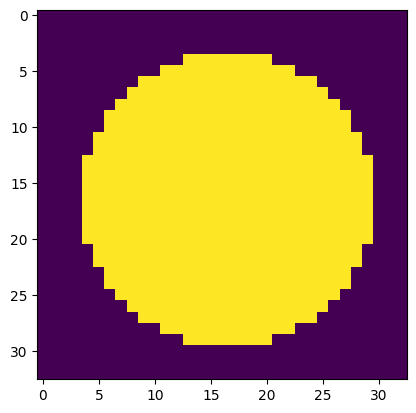

In [118]:
plt.imshow(utrue.reshape(33,33))

In [116]:
k

np.int64(3)

In [119]:
mean_us = us.mean(axis=0)
X = us - mean_us

U, S, Vt = np.linalg.svd(us / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
k = 1000
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_us + (z * S) @ V.T

In [120]:
us_pca = pca_encode(us)
us_ref_pca = pca_encode(us_ref)
us_test_pca = pca_encode(us_test)

target_data = jnp.hstack([ys_normalized, us_pca])
ref_data = jnp.hstack([ys_normalized, us_ref_pca])

In [127]:
key = random.PRNGKey(seed=42)
key1, key2 = random.split(key=key, num=2)
batch_size = 1000
steps = 200000
print_every = 10000
# yu_dimension = (100, k.item())
yu_dimension = (100, k)
dim = yu_dimension[0] + yu_dimension[1]
# hidden_layer_list = [2 ** 10] * 10
hidden_layer_list = [2 ** 10] * 20
model = MLP(
    key=key2,
    dim=dim,
    time_varying=True,
    w=hidden_layer_list,
    num_layers=len(hidden_layer_list) + 1,
    activation_fn=jax.nn.relu,  # GeLU worked well
)
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=2_000,
    decay_steps=steps,
    end_value=1e-5,
)
optimizer = optax.adam(schedule)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(schedule))
interpolant = linear_interpolant
interpolant_der = linear_interpolant_der
interpolant_args = {"t": None, "x1": None, "x0": None}

In [128]:
trainer = NNTrainer(
    target_density=None,
    model=model,
    optimizer=optimizer,
    interpolant=interpolant,
    interpolant_der=interpolant_der,
    reference_sampler=gaussian_reference_sampler,
    loss=vec_field_loss,
    interpolant_args=interpolant_args,
    yu_dimension=yu_dimension,
)
trainer.train(
    train_data=target_data,
    train_dim=train_dim,
    batch_size=batch_size,
    steps=steps,
    x0_data=ref_data,
    print_every=print_every
);

Training neural network


  0%|          | 13/200000 [00:04<13:02:56,  4.26it/s]

step = 0, train_loss = 25364.69140625


  5%|▌         | 10016/200000 [01:30<27:41, 114.38it/s]

step = 10000, train_loss = -654.40380859375


 10%|█         | 20015/200000 [02:58<26:13, 114.36it/s]

step = 20000, train_loss = -821.999755859375


 15%|█▌        | 30014/200000 [04:25<24:58, 113.47it/s]

step = 30000, train_loss = -888.8477783203125


 20%|██        | 40017/200000 [05:52<22:55, 116.35it/s]

step = 40000, train_loss = -936.296142578125


 25%|██▌       | 50014/200000 [07:19<21:42, 115.17it/s]

step = 50000, train_loss = -970.0564575195312


 30%|███       | 60014/200000 [08:45<20:16, 115.08it/s]

step = 60000, train_loss = -994.9774780273438


 35%|███▌      | 70018/200000 [10:12<18:14, 118.74it/s]

step = 70000, train_loss = -1009.2201538085938


 40%|████      | 80022/200000 [11:38<17:30, 114.16it/s]

step = 80000, train_loss = -1026.6519775390625


 45%|████▌     | 90014/200000 [13:05<16:00, 114.49it/s]

step = 90000, train_loss = -1039.8067626953125


 50%|█████     | 100024/200000 [14:32<14:20, 116.21it/s]

step = 100000, train_loss = -1049.7615966796875


 55%|█████▌    | 110022/200000 [15:59<12:50, 116.82it/s]

step = 110000, train_loss = -1067.1715087890625


 60%|██████    | 120018/200000 [17:26<11:45, 113.32it/s]

step = 120000, train_loss = -1070.61572265625


 65%|██████▌   | 130018/200000 [18:53<09:59, 116.82it/s]

step = 130000, train_loss = -1090.024169921875


 70%|███████   | 140018/200000 [20:19<08:39, 115.53it/s]

step = 140000, train_loss = -1102.5513916015625


 75%|███████▌  | 150020/200000 [21:46<07:11, 115.84it/s]

step = 150000, train_loss = -1111.5135498046875


 80%|████████  | 160013/200000 [23:13<05:45, 115.86it/s]

step = 160000, train_loss = -1120.6085205078125


 85%|████████▌ | 170017/200000 [24:39<04:20, 114.93it/s]

step = 170000, train_loss = -1121.25830078125


 90%|█████████ | 180013/200000 [26:06<02:52, 115.62it/s]

step = 180000, train_loss = -1124.5133056640625


 95%|█████████▌| 190014/200000 [27:33<01:25, 116.52it/s]

step = 190000, train_loss = -1126.6588134765625


100%|██████████| 200000/200000 [28:59<00:00, 114.97it/s]

step = 199999, train_loss = -1124.070068359375


In [129]:
yu_true = np.load("sl-data/data_sl.npy")
map_array = np.load("sl-data/map_array.npy")
utrue = yu_true[yu_dimension[0]:]
yobs = yu_true[:yu_dimension[0]]
# targets, yobs = read_data_h5()
ytrue_flat_normalized = ys_normalizer.encode(yobs)

cond_values = ytrue_flat_normalized
cond_samples = trainer.conditional_sample(
    cond_values=cond_values, u0_cond=us_test_pca, nsamples=20000
)

all_samples = cond_samples
u_samples = all_samples[:, yu_dimension[0] :]
u_samples = pca_decode(u_samples)
u_samples = u_samples.reshape(20000, nx, ny)
u_means = jnp.mean(u_samples, axis=0)
u_var = jnp.var(u_samples, axis=0)

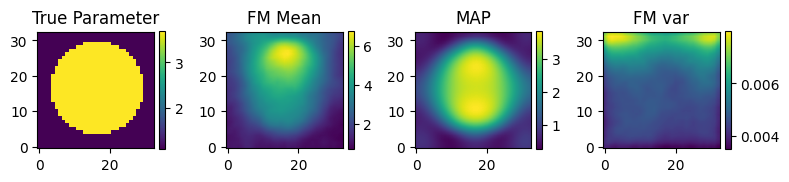

In [130]:
layer_idx = 0
fig, ax = plt.subplots(1, 4, figsize=(8, 8))

im0 = ax[0].imshow(utrue.reshape(33, 33), origin="lower")
ax[0].set_title("True Parameter")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(u_means, origin="lower", interpolation="bilinear")
ax[1].set_title("FM Mean")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(map_array, origin="lower", interpolation="bilinear")
ax[2].set_title("MAP")
ax[2].grid(False)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(u_var, origin="lower", interpolation="bilinear")
ax[3].set_title("FM var")
ax[3].grid(False)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

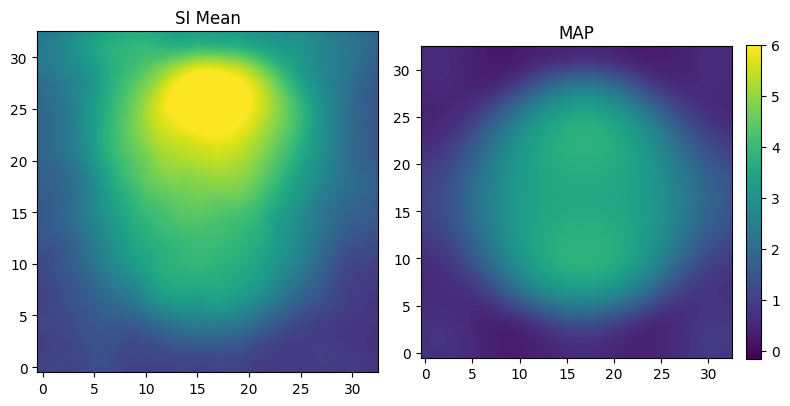

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(8,8))
vmin, vmax = -0.15, 6

im1 = ax[0].imshow(u_means, cmap="viridis", vmin=vmin, vmax=vmax, interpolation="bilinear", origin="lower")
ax[0].grid(False)
ax[0].set_title("SI Mean")
im2 = ax[1].imshow(map_array, cmap="viridis", vmin=vmin, vmax=vmax, interpolation="bilinear", origin="lower")
ax[1].grid(False)
ax[1].set_title("MAP")
fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()

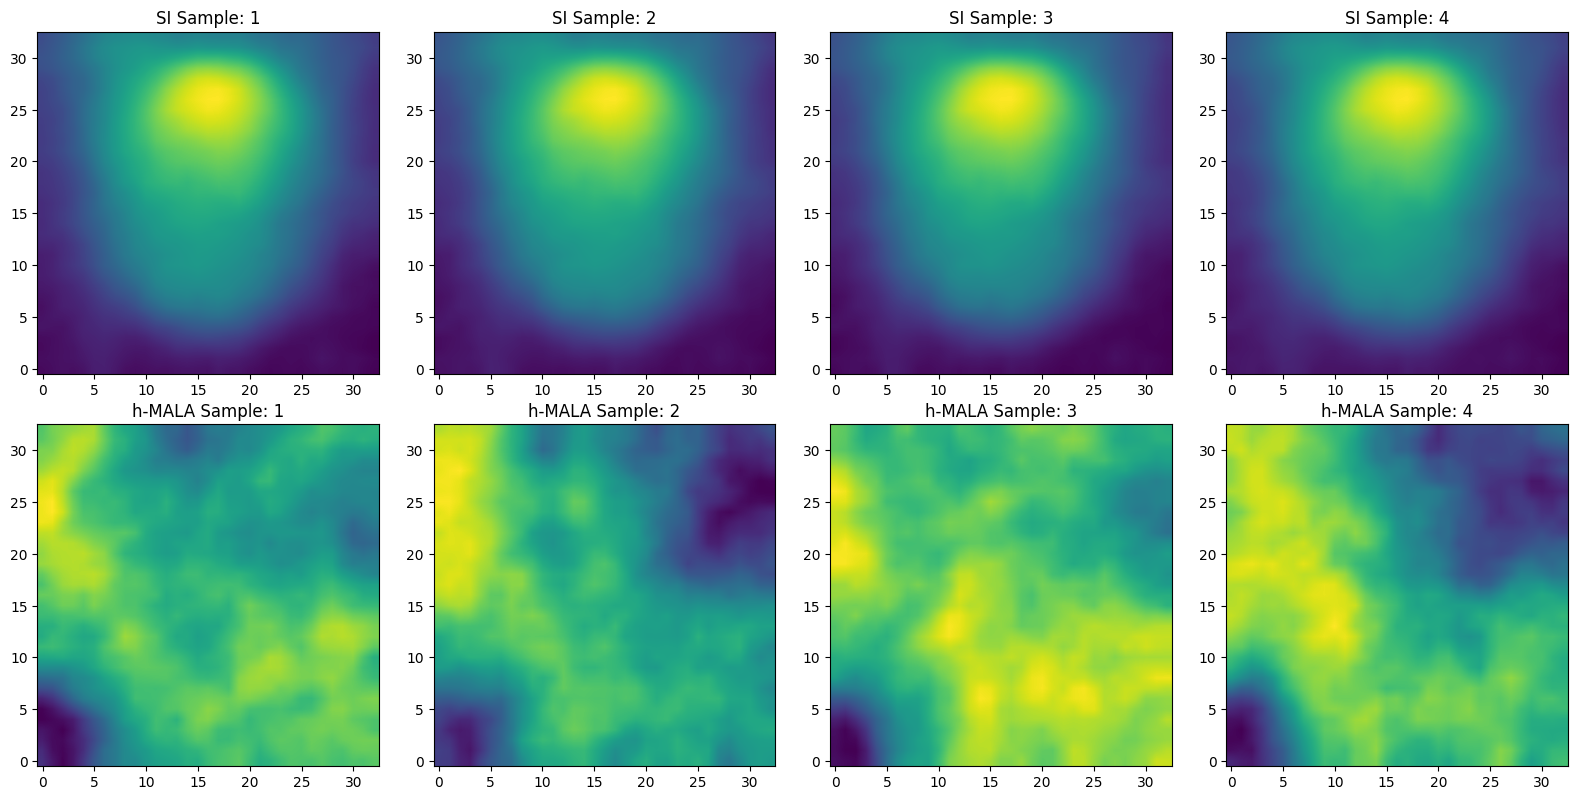

In [131]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for i in range(len(ax)):
    if i == 0:
        for j in range(len(ax[i])):
            ax[i][j].imshow(u_samples[np.random.choice(u_samples.shape[0]), :, :], origin="lower", interpolation="bilinear")
            ax[i][j].set_title(f"SI Sample: {j+1}")
            ax[i][j].grid(False)
    else:
        for j in range(len(ax[i])):
            ax[i][j].imshow(hmala_samps[np.random.choice(hmala_samps.shape[0]), :, :], origin="lower", interpolation="bilinear")
            ax[i][j].set_title(f"h-MALA Sample: {j+1}")
            ax[i][j].grid(False)
plt.tight_layout()

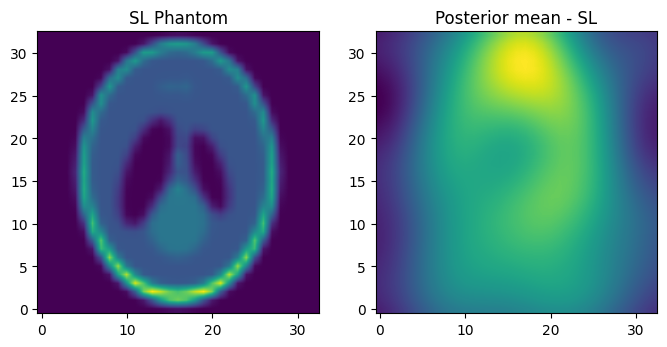

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(8,8))

im0 = ax[0].imshow(utrue.reshape(nx, ny, order="C"), origin="lower", interpolation="bilinear")
ax[0].set_title("SL Phantom")
ax[0].grid(False)

ax[1].imshow(u_means, origin="lower", interpolation="bilinear")
ax[1].set_title("Posterior mean - SL")
ax[1].grid(False)

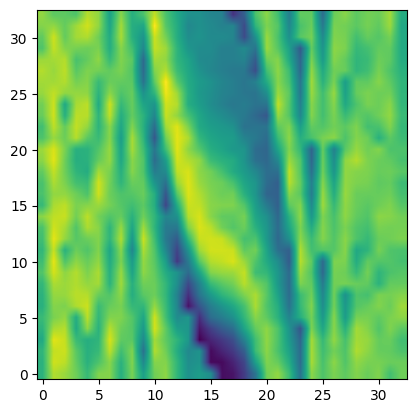

In [27]:
test_u = np.load("sl-data/parameters.npy")[: train_dim, :, :]
plt.imshow(test_u[0], origin="lower", interpolation="bilinear")

In [63]:
from ot.sliced import sliced_wasserstein_distance as swd
swd(np.array(u_samples.reshape(20000, 33 ** 2)), us_ref[np.random.choice(50000, 20000), :])

np.float64(2.001292672456142)

In [64]:
swd(us_ref[np.random.choice(50000, 20000), :], us_ref[np.random.choice(50000, 20000), :])

np.float64(0.0018624264441968077)

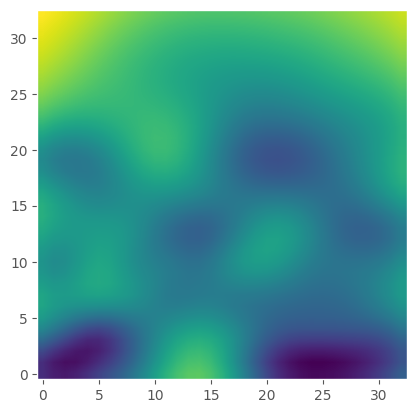

In [98]:
sl_samps = np.load("sl-data/hmala_samples.npy").reshape(nsamples, nx, ny)
plt.imshow(np.mean(sl_samps, axis=0), origin="lower", interpolation="bilinear")
plt.grid(False)

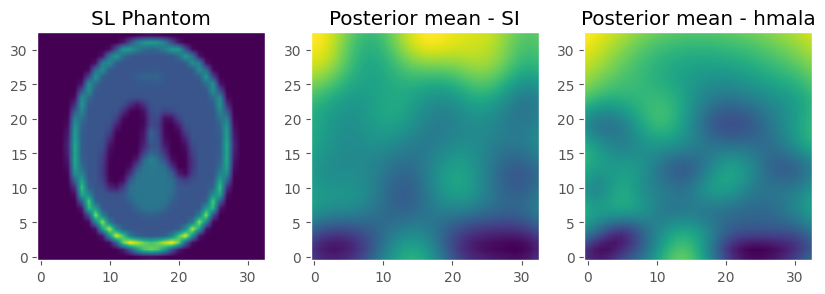

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(10,10))

ax[0].imshow(utrue.reshape(nx, ny, order="C"), origin="lower", interpolation="bilinear")
ax[0].set_title("SL Phantom")
ax[0].grid(False)

ax[1].imshow(u_means, origin="lower", interpolation="bilinear")
ax[1].set_title("Posterior mean - SI")
ax[1].grid(False)

ax[2].imshow(np.mean(sl_samps, axis=0), origin="lower", interpolation="bilinear")
ax[2].set_title("Posterior mean - hmala")
ax[2].grid(False)

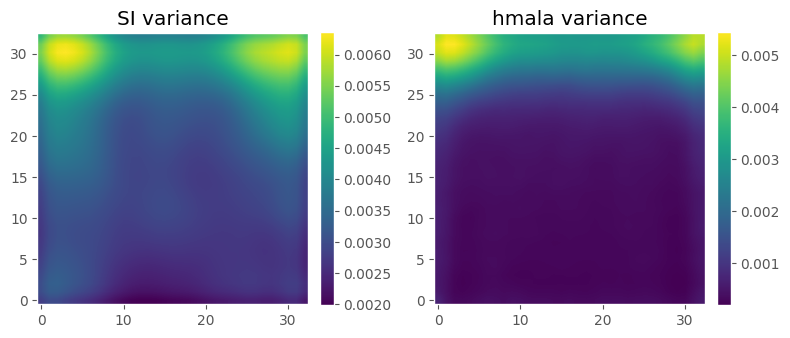

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(8,8))

im0 = ax[0].imshow(u_var, origin="lower", interpolation="bilinear")
ax[0].set_title("SI variance")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(np.var(sl_samps, axis=0), origin="lower", interpolation="bilinear")
ax[1].set_title("hmala variance")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [100]:
hmala_prior_swd = swd(np.array(sl_samps.reshape(20000, 33 ** 2)), us_ref[np.random.choice(50000, 20000), :], n_projections=5000, seed=42)
hmala_si_swd = swd(np.array(sl_samps.reshape(20000, 33 ** 2)), np.array(u_samples.reshape(20000, 33 ** 2)), n_projections=5000, seed=42)

In [101]:
hmala_si_swd / hmala_prior_swd

np.float64(0.48575491095228374)

In [102]:
hmala_si_swd

np.float64(0.336184421710471)

In [85]:
u_samples.shape

(20000, 33, 33)

In [86]:
np.save("sl-data/si-samps.npy", u_samples)